In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from IPython.display import Image, display
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, cifar10
from sklearn.metrics import classification_report, accuracy_score

# **ResNet-50**

##  1. **Deeper Networks without Vanishing Gradient:**


*   ResNet allows training very deep neural networks by introducing skip
connections or shortcuts.
*   These shortcuts help in avoiding the vanishing gradient problem, making it easier to train extremely deep models.

**__**



## 2.  **Residual Learning:**


*   ResNet introduces the concept of residual learning, where the model learns to predict the difference between the input and the actual output.
*   This facilitates the learning process by focusing on the residual information.

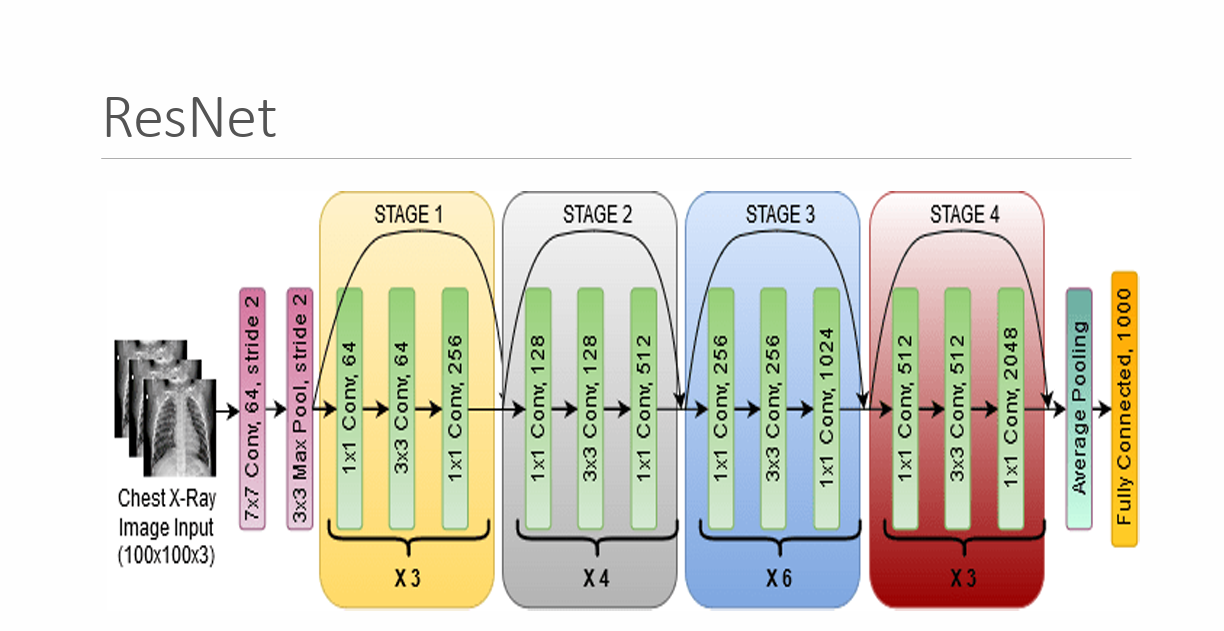

In [ ]:
display(Image(filename='/content/ResNet-50.png'))

In [ ]:
def identity_block(X, f, filters, stage, block):


    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. we'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape, outputClasses):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(outputClasses, activation='softmax', name='fc' + str(outputClasses),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
model = ResNet50(input_shape=(32, 32, 3),outputClasses=10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 38, 38, 3)            0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

In [ ]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),batch_size=125)

Epoch 1/10
400/400 [==============================] - 27s 68ms/step - loss: 1.1656 - accuracy: 0.6269 - val_loss: 1.5279 - val_accuracy: 0.4538
Epoch 2/10
400/400 [==============================] - 27s 67ms/step - loss: 1.2336 - accuracy: 0.5870 - val_loss: 581.9881 - val_accuracy: 0.1264
Epoch 3/10
400/400 [==============================] - 27s 67ms/step - loss: 1.0455 - accuracy: 0.6546 - val_loss: 1.1834 - val_accuracy: 0.6088
Epoch 4/10
400/400 [==============================] - 27s 67ms/step - loss: 0.8708 - accuracy: 0.7075 - val_loss: 1.1827 - val_accuracy: 0.5893
Epoch 5/10
400/400 [==============================] - 27s 67ms/step - loss: 0.9723 - accuracy: 0.6800 - val_loss: 1.1192 - val_accuracy: 0.6077
Epoch 6/10
400/400 [==============================] - 27s 69ms/step - loss: 0.8071 - accuracy: 0.7398 - val_loss: 2.4806 - val_accuracy: 0.5904
Epoch 7/10
400/400 [==============================] - 27s 67ms/step - loss: 0.6555 - accuracy: 0.7728 - val_loss: 0.9390 - val_accurac

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.0705 - accuracy: 0.6998


[1.0705381631851196, 0.6998000144958496]

313/313 [==============================] - 4s 9ms/step


Text(95.72222222222221, 0.5, 'Truth')

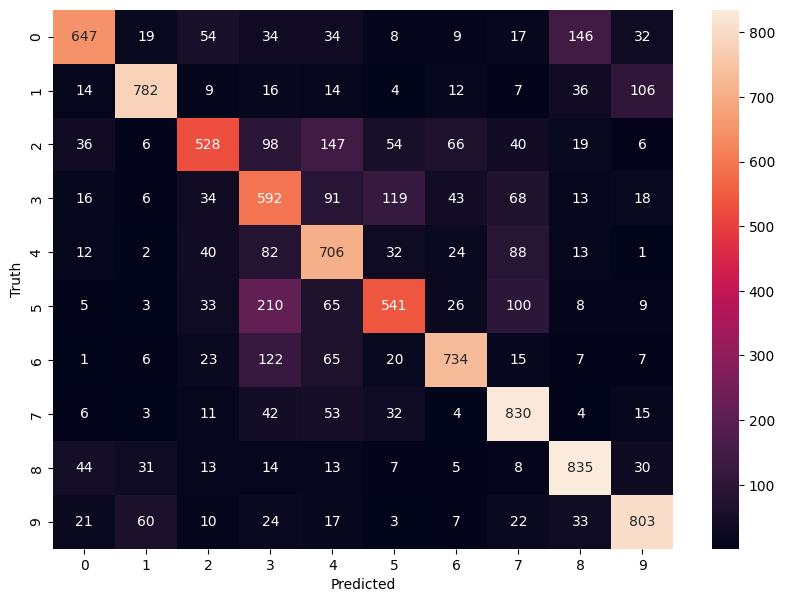

In [ ]:
y_pred = model.predict(x_test)
y_pred_labels=[np.argmax(element) for element in y_pred]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# Accuracy Score
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels)
print('Accuracy:', accuracy)

Accuracy: 0.8019999999999999


CIFAR

1.   Architecture 86% Train 70% Test

